# Plan 

## Preprocessing
## 1. Préparation des fonctions de modélisation
## 2. Préparation sur un échantillon de données
## 3. Entrainement des modèles et visualisation résultats
## 4. Selection du/des modèles et entrainement sur l'ensemble des données
## 5. Résultats et conclusion

In [1]:
from sklearn import metrics
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import pandas as pd 
import os
from termcolor import colored


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
splitted_path = os.getcwd().split("\\")[:-1]
path_dataset = "\\".join(splitted_path) + "\\notebook\\"
path_test = "\\".join(splitted_path) + "\\dataset\\"

In [3]:
data = pd.read_csv(path_dataset+r"preprocessed_df.csv",index_col=0)
test = pd.read_csv(path_dataset+"preprocessed_test.csv",index_col=0)
df = data.copy()

In [4]:
print("Dimension :", df.shape)
df.head()

Dimension : (188533, 13)


,id,model_year,milage,price,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,0,-1.559808,2.957842,4200,31,495,2,116,38,312,71,1,1
1,1,-2.443052,1.557184,4999,28,930,2,366,38,263,10,0,1
2,2,-2.443052,1.426276,13900,9,1575,1,640,38,38,71,1,1
3,3,0.206679,-0.927854,45000,16,758,2,863,49,29,14,1,1
4,4,0.913274,-1.171076,97500,36,1077,2,259,23,29,10,1,1


In [5]:
test.head()

,id,model_year,milage,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,-0.146618,0.648514,26.0,1390.0,2.0,325.0,16.0,304.0,10.0,1.0,1.0
1,188534,0.736626,-1.135854,26.0,1377.0,3.0,787.0,31.0,263.0,14.0,1.0,1.0
2,188535,1.089923,-0.754735,14.0,636.0,2.0,540.0,3.0,304.0,57.0,1.0,1.0
3,188536,0.030031,-0.089307,3.0,182.0,2.0,192.0,39.0,261.0,14.0,1.0,1.0
4,188537,0.383328,-0.134650,3.0,181.0,2.0,364.0,38.0,128.0,14.0,1.0,1.0


In [6]:
X = df.drop("price",axis=1)
y = df["price"]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

#### Code entrainement modélisation :

In [141]:
def train(model):
    """Fonction qui entraine un modèle et affiche le score obtenu sur 5 splits après
    cross validation et le score moyen. 
    Renvoi un tuple de trois éléments :
    (predictions, temps d'execution, le modèle entrainé)"""
    
    scores = cross_val_score(estimator=model, X=X_train.values, y=y_train)
    
    start_time = time.time()
    
    model.fit(X_train,y_train)
    
    end_time = time.time()
    
    # durée totale de l'entrainement 
    training_time = round(end_time - start_time,2)
    
    # Durée en minute :
    training_time_min = round(training_time/60,2)

    yp = model.predict(X_test.values)
    
    print(colored(type(model).__name__,"light_green",attrs=["bold"]))
    print("Scores sur 5 splits : ", [i.round(3) for i in scores])
    print("Score moyen :", scores.mean().round(3))

    return (yp, training_time_min, model)

def mesure(prediction, model):
    """
    Renvoi un dataframe contenant les valeurs des différentes
    metrics enregistrées à partir des prédicions d'un modèle:
    RMSLE,RMSE, MSE,MAE & R²
    return : Dataframe
    """

    # Calcul des différentes metrics rmse,mse, mae,R²
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mse = mean_squared_error(y_test, prediction, squared=True)
    mae = median_absolute_error(y_test, prediction)
    r2 = r2_score(y_test, prediction)
    

    # Récupération de l'ensemble des metrics
    all_metric = [rmse, mse, mae, r2]
    index_metric = ["RMSE", "MSE", "MAE", "R²"]

    metric_series = pd.Series(all_metric, name=str(model), index=index_metric)

    return pd.DataFrame(metric_series).T

def trainig_series(list_models):
    """Fonction qui entraine en série plusieurs modèle à la fois
    Renvoie un tuple contenant 4 éléments :
    DataFrame contenant toutes les métrics
    DataFrame contenant toutes les prédictions de modèles
    Dictionnaire contenant tout les modèles préentrainés
    Dictionnaire contenant le temps d'entrainement de chaque modèle
    """
    #Dictionnaire qui contiendra les différentes metrics de chaque modèle
    dict_metric = {}
    #dictionnaire contenant les valeurs prédictives pour chaque modèles
    dict_prediction = {}
    #dictionnaire contenant les modele entrainé
    dict_model_trained = {}
    #dictionnaire contenant le temps d'exécution 
    dict_time ={}
        
    
    for current_model in list_models:
        #Recuperation des prédictions et du temps d'execution de chaque modèles
        prediction, temps_exe, model_trained = train(current_model)

        # Récupération du nom du modèle et du chemin d'enregistrement
        model_name = type(current_model).__name__

        # Enregitrement des modèles après entrainement : 
        dict_model_trained[model_name] = model_trained

        #Enregistrement des prédiction dans le dictionnaire :
        dict_prediction[model_name] = prediction

        # Enregistrement des métriques au dictionnaire
        dict_metric[model_name] = mesure(prediction=prediction, model=model_name)
        
        #Enregistrement du tps d'execution
        dict_time[model_name] = temps_exe  
        
    #Pour les Dataframe :    
    # Concaténation des métriques en un DataFrame et inversion des colonnes et index :
    df_metrics = pd.concat(dict_metric.values(), axis=1).T 
    #Enregistrement des prédictions dans un dataframe :
    df_prediction = pd.DataFrame(dict_prediction)
    
    return (df_metrics,df_prediction,dict_model_trained, dict_time)

#### Code de visualisation :

In [142]:
 #visualisation du temp d'entrainement
def graph_time(dictionnary_time):
    """Fonction qui récupère un dictionnaire contenant les informations sur la durée d'entrainement des modèles et renvoie un barplot"""
    df_time = pd.DataFrame.from_dict(dictionnary_time, orient = "index", columns=["Duree d'entrainement"])
    plt.figure(figsize=(16,4))
    plt.grid()
    ax = sns.barplot(x = df_time.index, y = df_time.columns[0], data = df_time)
    ax.set_xticklabels(labels = df_time.index, rotation = 45)
    plt.xlabel("Modèles")
    plt.title("Durée d'entrainement des différents modèles (en minutes)")
    plt.show()

    
#Visualisation des metrics avec un barplot
def metric_plot(df_metric):
    mesure_reset = df_metric.reset_index()
    # Ensuite, ON utilise melt avec le nouvel index comme id_vars
    metric_df_melt = mesure_reset.melt(id_vars="index", var_name="Model", value_name="Score")

    plt.figure(figsize=(16,6))
    plt.grid()
    sns.barplot(data=metric_df_melt, x="index", y="Score", hue="Model")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Comparaison des scores des modèles')
    plt.show()
    
    
def visualisation_pred_real(model):
    """
    Fonction qui récupère les prédictions d'un modèle et affiche un graphique en comparant avec les valeurs réelles
    les valeurs réelles sont sur l'axe des x et les valeurs prédites sont sur l'axe des y.
    La ligne rouge en pointillés représente une correspondance parfaite entre les valeurs réelles et prédites. 
    Dans un modèle parfait, tous les points se situeraient le long de cette ligne.
    return : scatterplot
    """
    # Supposons que y_test contient les vraies valeurs et y_pred contient les valeurs prédites par votre modèle
    y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 4))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5) #scatterplot avec les vraies valeurs en x et les valeurs prédites en y

    # Ajouter une ligne diagonale pour indiquer une correspondance parfaite entre les valeurs réelles et prédites
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    # Label et  titre
    plt.title('Scatter Plot des Valeurs Réelles vs. Prédites')
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.show()


In [143]:
def visualisation_pred_real(list_model,xsize=14,ysize=14):
    """
    Fonction qui récupère les prédictions d'un modèle et affiche un graphique en comparant avec les valeurs réelles
    les valeurs réelles sont sur l'axe des x et les valeurs prédites sont sur l'axe des y.
    La ligne rouge en pointillés représente une correspondance parfaite entre les valeurs réelles et prédites. 
    Dans un modèle parfait, tous les points se situeraient le long de cette ligne.
    return : scatterplot
    """
    
    plt.figure(figsize=(xsize,ysize))
    for i, model in enumerate(list_model,1):
        plt.subplot(4,2,i)    
        y_pred = list_model[model].predict(X_test)
        plt.scatter(y_test, y_pred, color='blue', alpha=0.5) #scatterplot avec les vraies valeurs en x et les valeurs prédites en y

        # Ajouter une ligne diagonale pour indiquer une correspondance parfaite entre les valeurs réelles et prédites
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

        # Label et  titre
        plt.title('Scatter Plot des Valeurs Réelles vs. Prédites')
        plt.xlabel('Valeurs Réelles')
        plt.ylabel('Valeurs Prédites')
    plt.tight_layout()
    plt.show()

#### Code enregistrement :

In [144]:
def enregistrement_model(pretrained_models):
    """Prend en entrée un dictionnaire sous forme {nom_modèle : modèle préentrainé}"""
    for i in pretrained_models:
        model_name = i
        current_model = pretrained_models[model_name]
        model_filename = os.path.join(f"{model_name}.pkl")
        #Enregistrement des modèles préentrainé :
        with open(model_filename, 'wb') as model_file:
            pickle.dump(current_model, model_file)
        print(f'{colored(model_name,"blue")} enregistré sous {colored(model_filename,"green")}')


In [145]:
all_model = [DummyRegressor(strategy="mean"), 
              LinearRegression(), 
               Ridge(), Lasso(), ElasticNet(),RandomForestRegressor(), AdaBoostRegressor(), XGBRegressor()
            ]

In [146]:
#Entrainement en série :
mesure, prediction,model_entraine, exe_time = trainig_series(all_model)

DummyRegressor
Scores sur 5 splits :  [-0.0, -0.0, -0.0, -0.0, -0.0]
Score moyen : -0.0
LinearRegression
Scores sur 5 splits :  [0.116, 0.083, 0.111, 0.098, 0.085]
Score moyen : 0.099
Ridge
Scores sur 5 splits :  [0.116, 0.083, 0.111, 0.098, 0.085]
Score moyen : 0.099
Lasso
Scores sur 5 splits :  [0.116, 0.083, 0.111, 0.098, 0.085]
Score moyen : 0.099
ElasticNet
Scores sur 5 splits :  [0.112, 0.079, 0.105, 0.093, 0.081]
Score moyen : 0.094
RandomForestRegressor
Scores sur 5 splits :  [0.033, 0.049, 0.06, 0.033, 0.049]
Score moyen : 0.044
AdaBoostRegressor
Scores sur 5 splits :  [0.128, -1.201, 0.103, 0.108, 0.099]
Score moyen : -0.153
XGBRegressor
Scores sur 5 splits :  [0.041, 0.044, 0.08, 0.066, 0.048]
Score moyen : 0.056


In [147]:
#Sauvegarde des modèles préentrainé :
enregistrement_model(model_entraine)

DummyRegressor enregistré sous DummyRegressor.pkl
LinearRegression enregistré sous LinearRegression.pkl
Ridge enregistré sous Ridge.pkl
Lasso enregistré sous Lasso.pkl
ElasticNet enregistré sous ElasticNet.pkl
RandomForestRegressor enregistré sous RandomForestRegressor.pkl
AdaBoostRegressor enregistré sous AdaBoostRegressor.pkl
XGBRegressor enregistré sous XGBRegressor.pkl


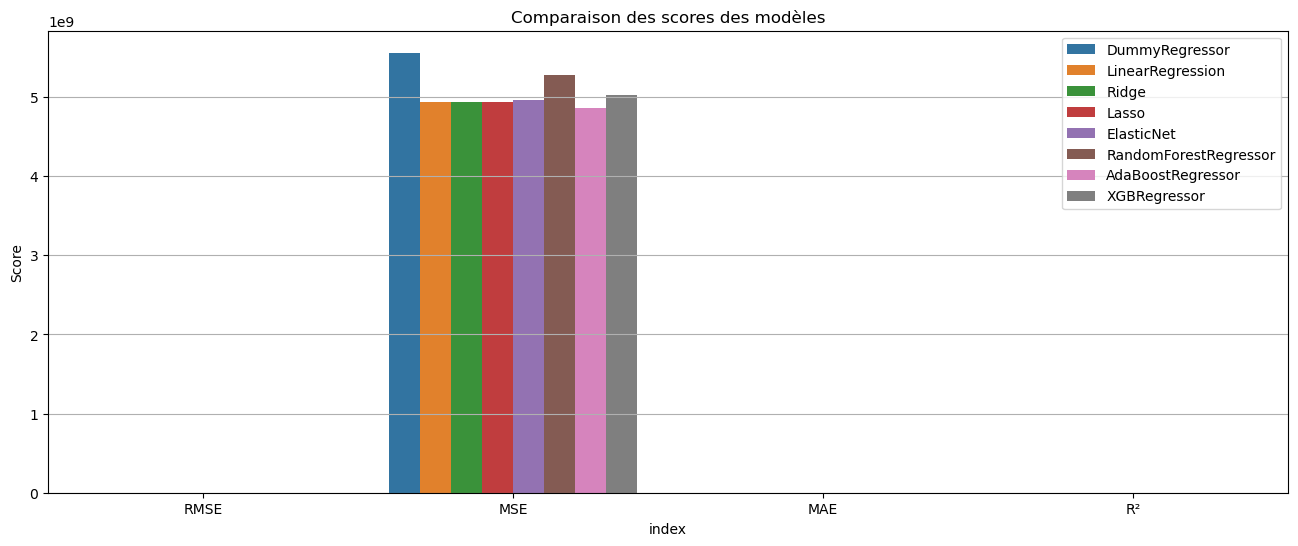

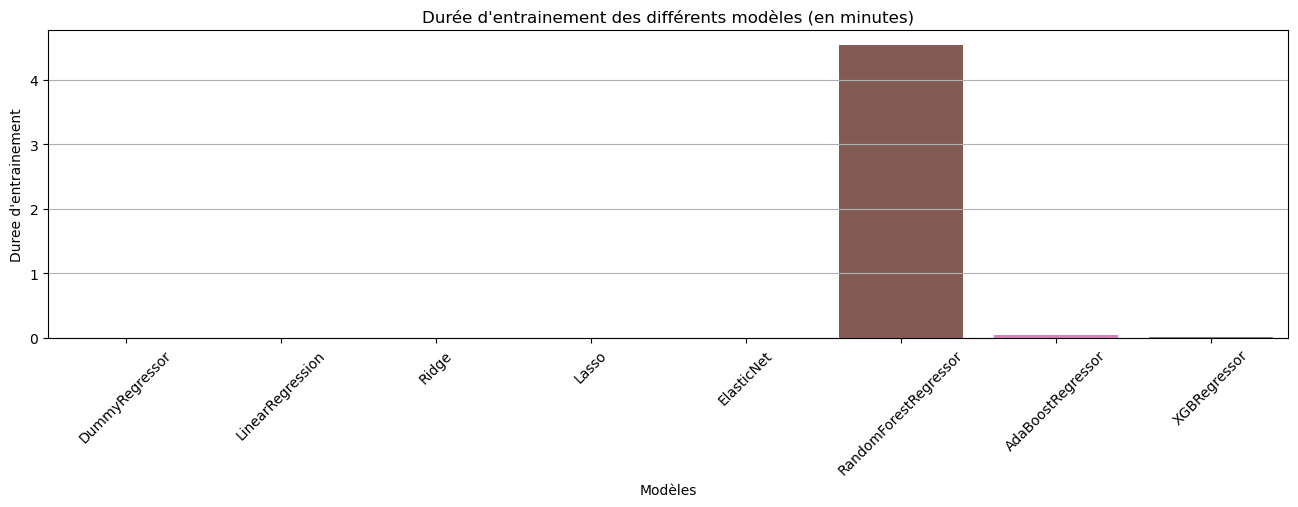

In [148]:
metric_plot(mesure)
graph_time(exe_time)

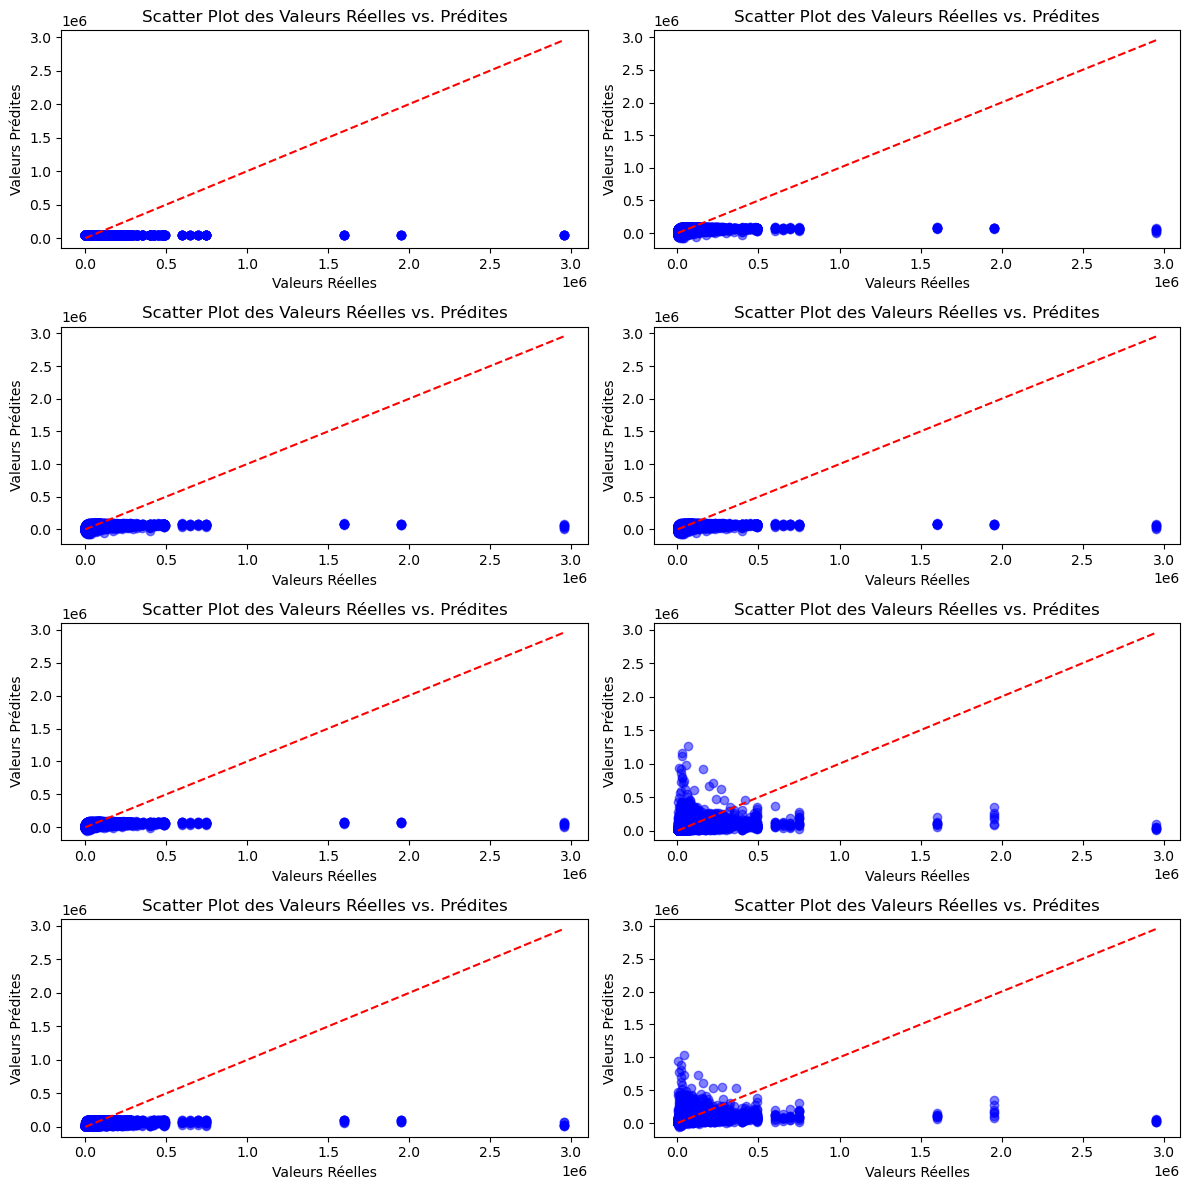

In [149]:
visualisation_pred_real(model_entraine,12,12)

#### observation :


Pour rappel, plus les valeurs sont proches de 0 et mieux sont les résultats 
- Meilleur modèles : RandomforestRegressor, XGBRegressor

## prédiction sur les données test : 

In [7]:
def new_prediction(model, data):
    #Récupération des mêmes features que celles utilisés pour l'entrainement des modèles
    columns = model.feature_names_in_
    #Récupération de l'id du jeu de données
    id_data = data["id"]
    #Préparation du dataframe à tester :
    X = data[columns]
    #Récupération des prédictions
    prediction = model.predict(X)
    
    #Transformation des prédictions en dataframe avec l'id en index
    prediction_df = pd.DataFrame(prediction, columns = ["price"], index = id_data)
    return prediction_df

In [8]:
def read_data(path):
    with open(path, 'rb') as file:
        loaded_file = pickle.load(file)
        name = path.split('/')[-1]
    print(f"Données chargées depuis {colored(path,'blue')} : {colored(name,'green',attrs=['bold'])}")
    return loaded_file

In [20]:
randomforest = read_data(os.getcwd()+"\\RandomForestRegressor.pkl")
xgb = read_data(os.getcwd()+"\\XGBRegressor.pkl")


Données chargées depuis D:\etude_data_science\Kaggle_competition\11_Regression_of_used_car_prices\notebook\RandomForestRegressor.pkl : D:\etude_data_science\Kaggle_competition\11_Regression_of_used_car_prices\notebook\RandomForestRegressor.pkl
Données chargées depuis D:\etude_data_science\Kaggle_competition\11_Regression_of_used_car_prices\notebook\XGBRegressor.pkl : D:\etude_data_science\Kaggle_competition\11_Regression_of_used_car_prices\notebook\XGBRegressor.pkl


In [16]:
new_prediction(randomforest, test).head()

,price
id,
188533,17309.42
188534,195978.45
188535,79282.60
188536,22595.26
188537,29026.86


In [18]:
new_prediction(randomforest, test).to_csv("prediction_randomforest.csv")

In [21]:
new_prediction(xgb, test).to_csv("prediction_xgb.csv")